In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle
import scipy.optimize as opt
pd.options.display.max_seq_items = 2000

In [2]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

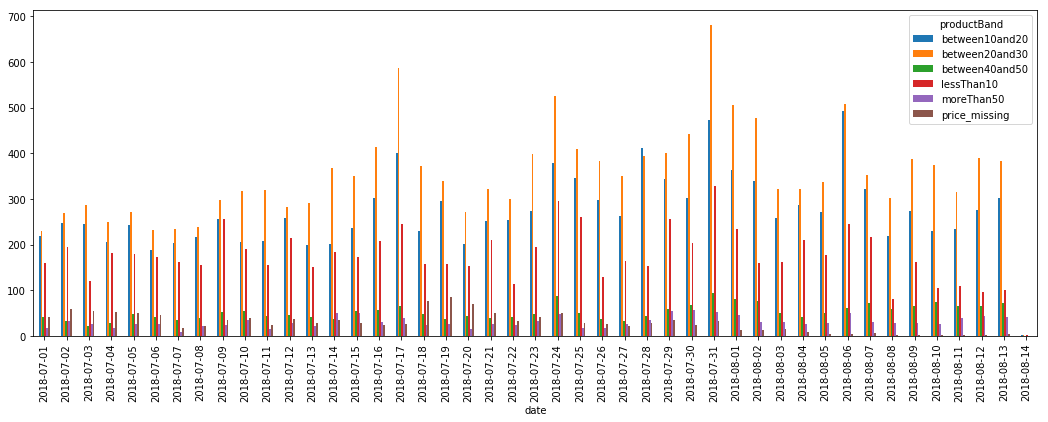

In [3]:
f, ax = plt.subplots(1,figsize=(18,6))
device_date=df.groupby(by=['device_name', 'date']).sum()
df.groupby(by=['productBand', 'date']).sum()['total_products'].unstack(0).plot(kind='bar', ax=ax)

Note: the two graphs above have very different trends for the last two weeks, because of the way the data was imputed. The total_products trend is more accurate

We only want to do short term forecasting, the best way t do that is to presume that there is a weekly and monthly trend that needs to be taken into account and forecast based on this. First want to find any weekly trend.

In [4]:

df_e=df
df_e['weekday']=df['date'].apply(lambda x:pd.to_datetime(x).weekday())
device_weekday=df_e.groupby(by=['productBand', 'weekday']).sum()['total_products'].unstack(0)

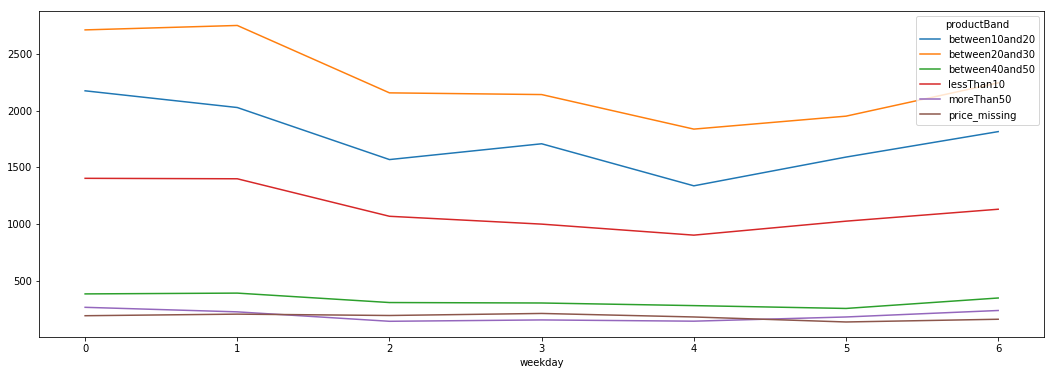

In [5]:
f, ax = plt.subplots(1,figsize=(18,6))
device_weekday.plot(ax=ax)

Remove this signal from the monthly data. Then find the monthly trend and combine them.

In [6]:
device_weekday['between20and30']

weekday
0    2710.0
1    2749.0
2    2156.0
3    2141.0
4    1837.0
5    1951.0
6    2244.0
Name: between20and30, dtype: float64

In [7]:
modelling_df=df.groupby(by=['productBand', 'date']).sum()['total_products'].unstack(0)

In [8]:
modelling_df.head(10)

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing
date,,,,,,
2018-07-01,219.0,230.0,41.0,160.0,18.0,42.0
2018-07-02,247.0,269.0,32.0,195.0,32.0,60.0
2018-07-03,246.0,286.0,22.0,121.0,26.0,55.0
2018-07-04,206.0,250.0,28.0,182.0,17.0,52.0
2018-07-05,242.0,271.0,47.0,179.0,27.0,51.0
2018-07-06,188.0,231.0,41.0,172.0,26.0,46.0
2018-07-07,204.0,233.0,34.0,162.0,8.0,18.0
2018-07-08,216.0,239.0,39.0,156.0,21.0,21.0
2018-07-09,256.0,298.0,52.0,257.0,25.0,35.0


In [9]:
modelling_df.columns

Index(['between10and20', 'between20and30', 'between40and50', 'lessThan10',
       'moreThan50', 'price_missing'],
      dtype='object', name='productBand')

In [10]:
def scale_total_products_modelling(row,dwd,col):
    scaler=dwd[col].apply(lambda x:x/dwd[col].mean())
    weekday_temp=pd.to_datetime(row.name).weekday()
    #print(scaler,weekday_temp,scaler[weekday_temp])
    return row[col]/scaler[weekday_temp]
modelling_df_new=modelling_df
for column in modelling_df.columns:
    modelling_df_new[column]=modelling_df.apply(lambda row:scale_total_products_modelling(row,device_weekday,column),axis=1)

In [11]:
modelling_df_new.head(10)

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing
date,,,,,,
2018-07-01,210.674380,231.171378,38.263329,160.282686,14.660344,47.707317
2018-07-02,198.372585,223.878334,27.086010,157.500000,23.349973,57.318681
2018-07-03,211.897385,234.649899,18.290790,98.010000,22.285714,49.022556
2018-07-04,229.239006,261.529287,29.491961,192.885981,22.855186,49.171864
2018-07-05,247.384075,285.483953,50.149372,202.783217,33.542495,44.188704
2018-07-06,245.327354,283.616766,47.290241,215.761062,34.717201,46.571429
2018-07-07,223.874293,269.356667,43.001655,178.878286,8.534161,23.951020
2018-07-08,207.788430,240.217214,36.396825,156.275618,17.103734,23.853659
2018-07-09,205.600736,248.013917,44.014766,207.576923,18.242167,33.435897


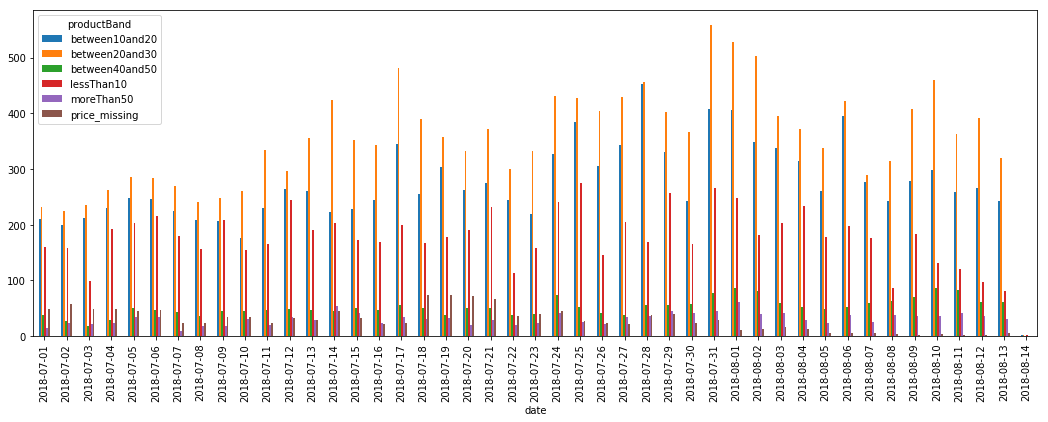

In [12]:
f, ax = plt.subplots(1,figsize=(18,6))
modelling_df_new.plot(kind='bar', ax=ax)

Now we can model the sales for the month, with weekly trends removed. Then combine the two later. Given more time, these could be fit simulatneously, but it's better to start with the basics.

In [13]:
modelling_df_new.index

Index(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
       '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
       '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15',
       '2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
       '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25',
       '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
       '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04',
       '2018-08-05', '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
       '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13', '2018-08-14'],
      dtype='object', name='date')

In [14]:
modelling_df_new.shape

(45, 6)

In [15]:
modelling_month=modelling_df_new[pd.to_datetime(modelling_df_new.index).month<8]
modelling_month.shape

(31, 6)

In [16]:
modelling_month

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing
date,,,,,,
2018-07-01,210.674380,231.171378,38.263329,160.282686,14.660344,47.707317
2018-07-02,198.372585,223.878334,27.086010,157.500000,23.349973,57.318681
2018-07-03,211.897385,234.649899,18.290790,98.010000,22.285714,49.022556
2018-07-04,229.239006,261.529287,29.491961,192.885981,22.855186,49.171864
2018-07-05,247.384075,285.483953,50.149372,202.783217,33.542495,44.188704
2018-07-06,245.327354,283.616766,47.290241,215.761062,34.717201,46.571429
2018-07-07,223.874293,269.356667,43.001655,178.878286,8.534161,23.951020
2018-07-08,207.788430,240.217214,36.396825,156.275618,17.103734,23.853659
2018-07-09,205.600736,248.013917,44.014766,207.576923,18.242167,33.435897


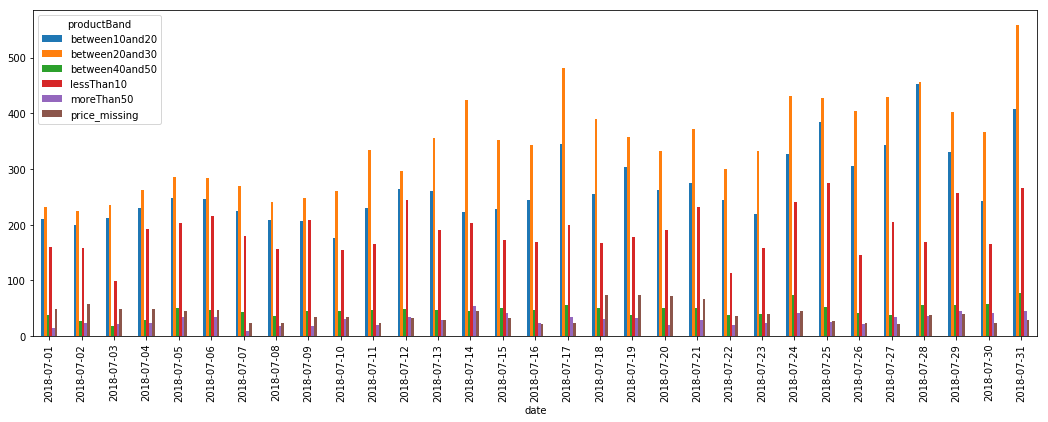

In [17]:
f, ax = plt.subplots(1,figsize=(18,6))
modelling_month.plot(kind='bar', ax=ax)

Can use this as a very simplistic model

In [18]:
modelling_month.reset_index(inplace=True)

In [19]:
modelling_month['day_of_month']=modelling_month['date'].apply(lambda x:pd.to_datetime(x).day)
modelling_month.drop(['price_missing'],axis=1,inplace=True)

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [20]:
modelling_month

productBand,date,between10and20,between20and30,between40and50,lessThan10,moreThan50,day_of_month
0,2018-07-01,210.674380,231.171378,38.263329,160.282686,14.660344,1
1,2018-07-02,198.372585,223.878334,27.086010,157.500000,23.349973,2
2,2018-07-03,211.897385,234.649899,18.290790,98.010000,22.285714,3
3,2018-07-04,229.239006,261.529287,29.491961,192.885981,22.855186,4
4,2018-07-05,247.384075,285.483953,50.149372,202.783217,33.542495,5
5,2018-07-06,245.327354,283.616766,47.290241,215.761062,34.717201,6
6,2018-07-07,223.874293,269.356667,43.001655,178.878286,8.534161,7
7,2018-07-08,207.788430,240.217214,36.396825,156.275618,17.103734,8
8,2018-07-09,205.600736,248.013917,44.014766,207.576923,18.242167,9
9,2018-07-10,176.581154,260.083979,44.895577,154.710000,30.000000,10


In [21]:
real_august=modelling_df_new[pd.to_datetime(modelling_df_new.index).month==8]
real_august=real_august[pd.to_datetime(real_august.index).day<13]
real_august#not sure if last two days have all the data, so use up to the 12th

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing
date,,,,,,
2018-08-01,405.063098,528.289160,85.316031,247.996262,60.499022,11.347353
2018-08-02,347.564403,502.493895,81.092601,181.258741,38.511754,12.130233
2018-08-03,336.672646,395.344584,58.824447,201.962389,41.393586,15.186335
2018-08-04,314.960402,372.243977,51.854937,232.983447,28.802795,11.975510
2018-08-05,260.697521,337.711230,47.595849,178.314488,23.619443,4.543554
2018-08-06,395.138914,422.788824,51.632706,197.076923,37.214020,4.776557
2018-08-07,276.500247,288.799875,59.029369,175.770000,25.714286,5.347915
2018-08-08,242.592734,314.881262,63.197060,85.844860,37.643836,2.836838
2018-08-09,279.073770,407.683726,69.355514,183.524476,36.027125,1.732890


In [22]:
def movingaverage(interval, window_size):
    """ 
    A function to calculate a moving average, useful for looking at data trends and for dampening noise in a less artificial way.
    """
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [23]:
matching_august=modelling_month[modelling_month['day_of_month']<13]
matching_august

productBand,date,between10and20,between20and30,between40and50,lessThan10,moreThan50,day_of_month
0,2018-07-01,210.674380,231.171378,38.263329,160.282686,14.660344,1
1,2018-07-02,198.372585,223.878334,27.086010,157.500000,23.349973,2
2,2018-07-03,211.897385,234.649899,18.290790,98.010000,22.285714,3
3,2018-07-04,229.239006,261.529287,29.491961,192.885981,22.855186,4
4,2018-07-05,247.384075,285.483953,50.149372,202.783217,33.542495,5
5,2018-07-06,245.327354,283.616766,47.290241,215.761062,34.717201,6
6,2018-07-07,223.874293,269.356667,43.001655,178.878286,8.534161,7
7,2018-07-08,207.788430,240.217214,36.396825,156.275618,17.103734,8
8,2018-07-09,205.600736,248.013917,44.014766,207.576923,18.242167,9
9,2018-07-10,176.581154,260.083979,44.895577,154.710000,30.000000,10


Fit the two weeks to each other as a basic forecast. essentially I am using the previous month trend and presuming that the purchases will act in the exact same way (as opposed to some continued decrease).

In [24]:
#between20and30 first
y=matching_august['between20and30'].values
x1=real_august['between20and30'].values
o0=[1.]
errfunc = lambda o, x1, y: x1*o - y # Distance to the target function, through linear combination.
o1, success = opt.leastsq(errfunc, o0[:], args=(x1, y))
scaler_20to30=o1[0]
print(o1,success)

[0.63769558] 3


In [25]:
y=matching_august['between10and20'].values
x1=real_august['between10and20'].values
o0=[1.]
errfunc = lambda o, x1, y: x1*o - y # Distance to the target function, through linear combination.
o1, success = opt.leastsq(errfunc, o0[:], args=(x1, y))

scaler_10to20=o1[0]
print(o1,success)

[0.6988843] 3


In [26]:
forecast_august=modelling_month
import datetime
def add_one_month(orig_date):
    # advance year and month by one month
    year = orig_date.year
    month = orig_date.month + 1
    day = orig_date.day
    return datetime.date(year, month, day)
forecast_august['date']=forecast_august['date'].apply(lambda x:add_one_month(pd.to_datetime(x)))
forecast_august

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


productBand,date,between10and20,between20and30,between40and50,lessThan10,moreThan50,day_of_month
0,2018-08-01,210.674380,231.171378,38.263329,160.282686,14.660344,1
1,2018-08-02,198.372585,223.878334,27.086010,157.500000,23.349973,2
2,2018-08-03,211.897385,234.649899,18.290790,98.010000,22.285714,3
3,2018-08-04,229.239006,261.529287,29.491961,192.885981,22.855186,4
4,2018-08-05,247.384075,285.483953,50.149372,202.783217,33.542495,5
5,2018-08-06,245.327354,283.616766,47.290241,215.761062,34.717201,6
6,2018-08-07,223.874293,269.356667,43.001655,178.878286,8.534161,7
7,2018-08-08,207.788430,240.217214,36.396825,156.275618,17.103734,8
8,2018-08-09,205.600736,248.013917,44.014766,207.576923,18.242167,9
9,2018-08-10,176.581154,260.083979,44.895577,154.710000,30.000000,10


In [27]:
forecast_august.set_index('date',inplace=True)

Drop the columns we are not using. It's not a great idea to forecast using these columns anyway because they have much lower sales.

In [28]:
forecast_august.drop(['day_of_month','lessThan10','moreThan50','between40and50'],axis=1,inplace=True)

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [30]:
fail#want this to fail and not run twice
forecast_august['between20and30']=forecast_august['between20and30'].apply(lambda x:x*scaler_20to30)
forecast_august['between10and20']=forecast_august['between10and20'].apply(lambda x:x*scaler_10to20)
forecast_august

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


productBand,between10and20,between20and30
date,,
2018-08-01,147.237017,147.416965
2018-08-02,138.639486,142.766223
2018-08-03,148.091757,149.635202
2018-08-04,160.211543,166.776069
2018-08-05,172.892847,182.051854
2018-08-06,171.455437,180.861157
2018-08-07,156.462229,171.767555
2018-08-08,145.220072,153.185455
2018-08-09,143.691127,158.157378


In [31]:
move_av_20to30=movingaverage(forecast_august['between20and30'].values,4)
move_av_10to20=movingaverage(forecast_august['between10and20'].values,4)
print(len(move_av_20to30))

31


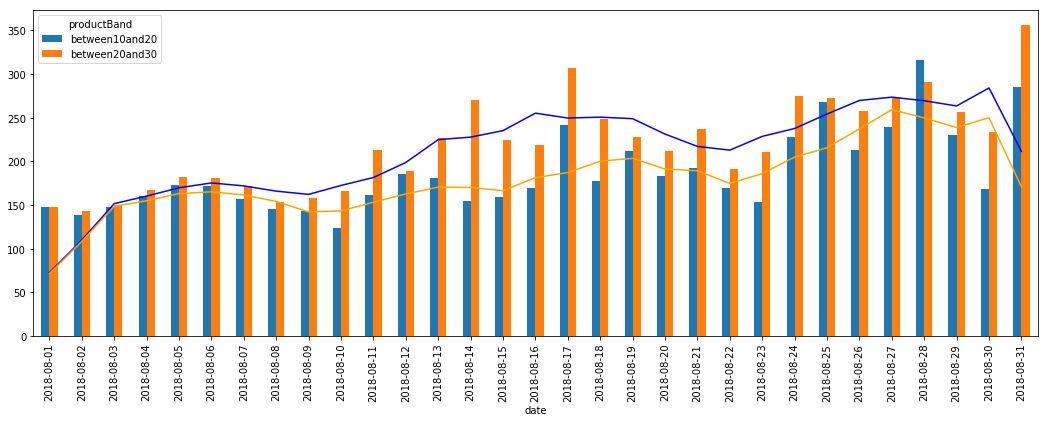

In [32]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august.plot(kind='bar', ax=ax)
ax.plot(move_av_20to30,color='blue')
ax.plot(move_av_10to20,color='orange')

Estimate the sales of the new line from this forecasting.

In [33]:
def salescount(B12,B23):
    var1,var2=0.2874626249476287,0.12559616376637636
    return (var1*B12+var2*B23)/2.

In [34]:
forecast_august['between30and40']=forecast_august.apply(lambda x:salescount(x['between10and20'],x['between20and30']),axis=1)
forecast_august

c:\users\joseph\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


productBand,between10and20,between20and30,between30and40
date,,,
2018-08-01,147.237017,147.416965,30.420072
2018-08-02,138.639486,142.766223,28.892280
2018-08-03,148.091757,149.635202,30.682226
2018-08-04,160.211543,166.776069,33.500633
2018-08-05,172.892847,182.051854,36.282623
2018-08-06,171.455437,180.861157,36.001249
2018-08-07,156.462229,171.767555,33.275195
2018-08-08,145.220072,153.185455,30.492424
2018-08-09,143.691127,158.157378,30.584894


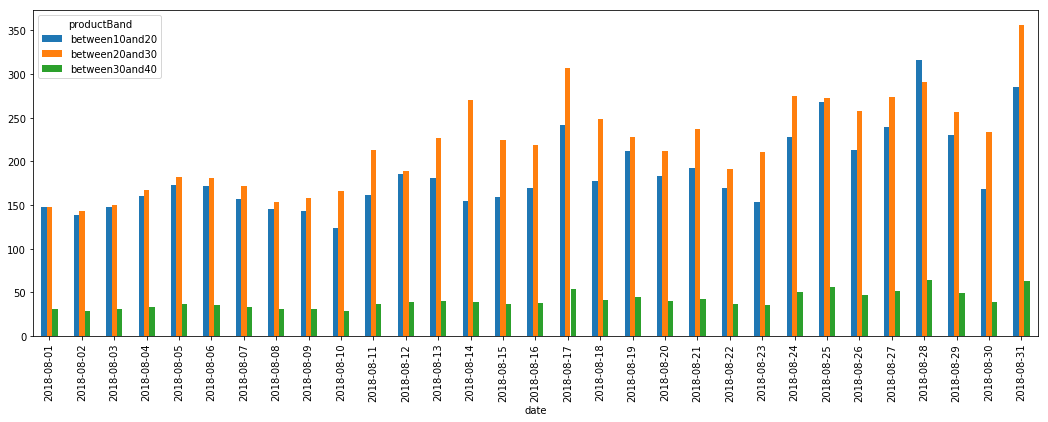

In [35]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august.plot(kind='bar', ax=ax)